<a href="https://colab.research.google.com/github/MichalRozenwald/epiCausality/blob/main/bisulfite_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

path = "Data"
celltypes = ["hepg2", "pancreas", "lb"]
N_SAMPLES = 10000
cancer_probs = [0.75, 1.0, 1.0, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 0.3]
pancreas_probs = [0.43, 0.43, 0.67, 0.33, 0.5 , 0.33, 0.2 , 0.  , 0.33, 0.  ]
lb_probs = [0.5, 0.0, 0.25, 0.25, 0.25, 0.25, 0.5, 0.25, 0.0, 0.0] # lymphoblastoids
all_probs = [cancer_probs, pancreas_probs, lb_probs]

## Sample data given probs

In [ ]:
np.random.seed(1)
samples = []
for i in range(3):
    probs, celltype = all_probs[i], celltypes[i]
    Xi = np.empty((N_SAMPLES, 10))
    for j, P_methylated in enumerate(probs):
        Xi[:,j] = np.random.choice(2, size=N_SAMPLES, replace=True, p=[1-P_methylated,P_methylated])
    samples.append(Xi)
    np.savetxt(os.path.join(path, celltype + str(N_SAMPLES) + ".csv"), Xi, delimiter=",")

In [ ]:
samples = []
for celltype in celltypes:
    Xi = pd.read_csv(os.path.join(path, celltype + str(N_SAMPLES) + ".csv"), header=None).to_numpy()
    samples.append(Xi)

## Analyze

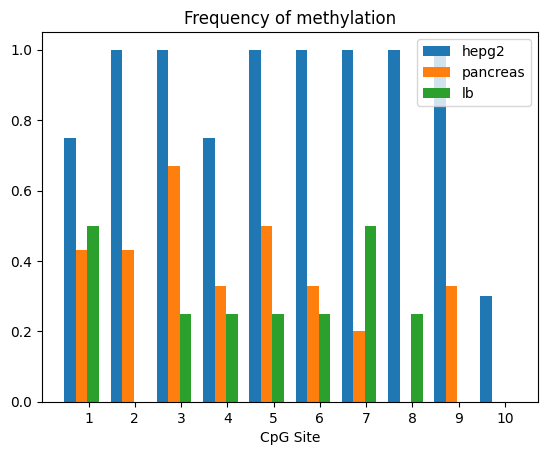

In [ ]:
import matplotlib.pyplot as plt
X_axis = np.arange(10)+1
shifts = [-.4,-.15,.1]
for i in range(3):
    plt.bar(X_axis+shifts[i], all_probs[i], .25,label=celltypes[i])
plt.legend()
plt.title("Frequency of methylation")
plt.xlabel("CpG Site")
plt.xticks(X_axis)
plt.show()


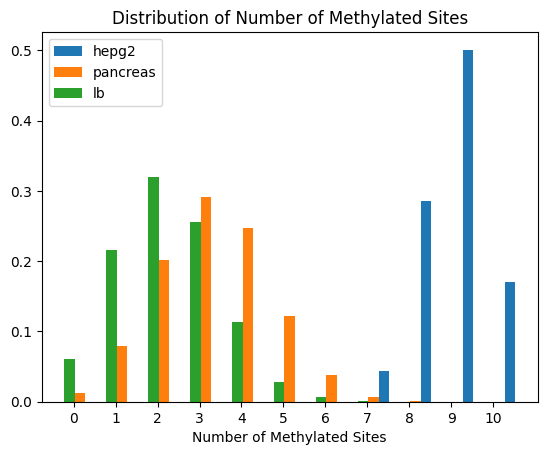

In [ ]:
X_axis2 = np.arange(11)
for i in range(3):
    counts = [np.mean(np.round(np.sum(samples[i], axis=1))==j) for j in range(11)]
    plt.bar(X_axis2-shifts[i], counts, .25,label=celltypes[i])
plt.legend()
plt.title("Distribution of Number of Methylated Sites")
plt.xlabel("Number of Methylated Sites")
plt.xticks(X_axis2)
plt.show()


## Model

In [ ]:
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import *
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import SVC, SVR
from sklearn.neural_network import MLPClassifier, MLPRegressor
X = np.array(samples).reshape(3*N_SAMPLES,-1)
train_idx, test_idx = train_test_split(np.arange(N_SAMPLES*3), train_size=.75,random_state=42)


- regression approach flattens out at 91% accuracy

In [ ]:

Y = np.repeat([0,50,100], N_SAMPLES)
X_train, X_test = X[train_idx], X[test_idx]
Y_train, Y_test = Y[train_idx], Y[test_idx]

def predict_reg(f, X, Y):
    preds = f.predict(X)
    preds012 = np.round(preds / 50) # 100-->2; 50-->1; 0-->0
    return np.mean(preds012*50==Y)*100

model = LinearRegression().fit(X_train,Y_train)
print("GLM: {:.2f}%".format(predict_reg(model, X_test, Y_test)))

print("####")
model = DecisionTreeRegressor().fit(X_train,Y_train)
print("Tree: {:.2f}%".format(predict_reg(model, X_test, Y_test)))
print("####")
model = RandomForestRegressor().fit(X_train,Y_train)
print("RF: {:.2f}%".format(predict_reg(model, X_test, Y_test)))
print("####")
model = GradientBoostingRegressor().fit(X_train,Y_train)
print("GBM: {:.2f}%".format(predict_reg(model, X_test, Y_test)))
print("####")
model = MLPRegressor(max_iter=1000,hidden_layer_sizes=(50,20)).fit(X_train, Y_train)
print("NN: {:.2f}%".format(predict_reg(model, X_test, Y_test)))

GLM: 86.87%
####
Tree: 91.13%
####
RF: 91.13%
####
GBM: 91.05%
####
NN: 91.07%


- 3-label classification: almost exactly the same, except logistic regression is better now.

In [ ]:
def predict(f, X, Y):
    preds = f.predict(X)
    return np.mean(preds==Y)*100

Y = np.repeat(celltypes, N_SAMPLES)
Y_train, Y_test = Y[train_idx], Y[test_idx]

# model = LogisticRegression(max_iter=1000).fit(X_train,Y_train)
# print("GLM: {:.2f}".format(predict(model, X_test, Y_test)))

# print("####")
# model = DecisionTreeClassifier().fit(X_train,Y_train)
# print("Tree: {:.2f}".format(predict(model, X_test, Y_test)))
# print("####")
# model = RandomForestClassifier().fit(X_train,Y_train)
# print("RF: {:.2f}".format(predict(model, X_test, Y_test)))
# print("####")
# model = GradientBoostingClassifier().fit(X_train,Y_train)
# print("GBM: {:.2f}".format(predict(model, X_test, Y_test)))
# print("####")
# # Same results regardless of architecture
# model = MLPClassifier(max_iter=1000,hidden_layer_sizes=(10,5)).fit(X_train, Y_train)
# print("NN: {:.2f}".format(predict(model, X_test, Y_test)))

model = LogisticRegression(max_iter=1000, penalty="l1", solver='saga').fit(X_train,Y_train)
print("Sparse GLM: {:.2f}".format(predict(model, X_test, Y_test)))


Sparse GLM: 91.12


In [ ]:
print(np.argsort(-np.abs(model.coef_), axis=1)+1)
print(np.abs(model.coef_))

[[ 8  1  2  3  4  5  6  7  9 10]
 [ 2  9  3  5  6  4  1  7  8 10]
 [ 8  7  1  2  3  4  5  6  9 10]]
[[ 0.          0.          0.          0.          0.          0.
   0.          0.82568647  0.          0.        ]
 [ 0.          8.67700454  1.79937721  0.39209453  1.01563429  0.46944213
   0.          0.          8.13799962  0.        ]
 [ 0.2388807   0.          0.          0.          0.          0.
   1.41448454 16.02751275  0.          0.        ]]


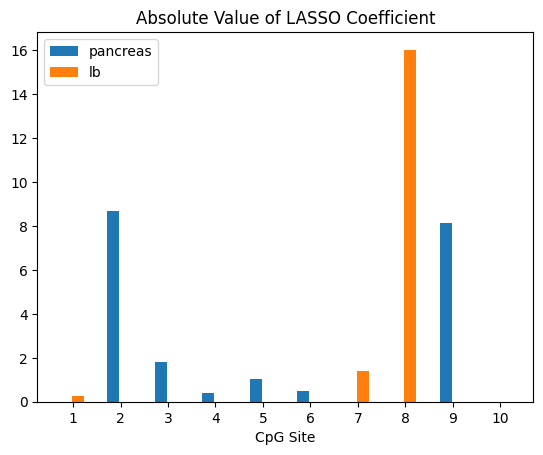

In [ ]:
for i in range(1,3):
    plt.bar(X_axis+shifts[i], np.abs(model.coef_[i]), .25,label=celltypes[i])
plt.legend()
plt.title("Absolute Value of LASSO Coefficient")
plt.xlabel("CpG Site")
plt.xticks(X_axis)
plt.show()


In [ ]:
import shap
# Xshap = shap.kmeans(X_train, 20)
explainer = shap.Explainer(model.predict, Xshap.data)
shapvals = explainer(X_test[:100])

TypeError: 'numpy.ndarray' object is not callable

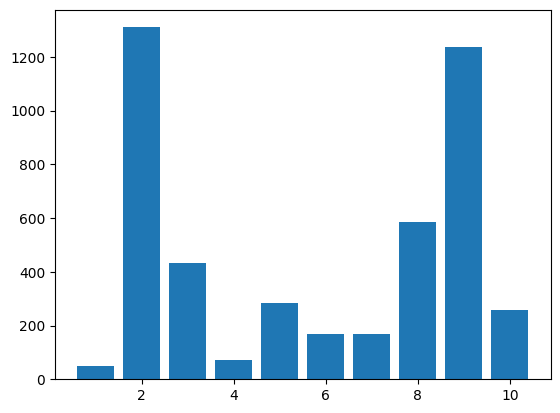

In [ ]:
sumabs = np.sum(np.abs(shapvals.values), axis=0)
plt.bar(X_axis, sumabs)
plt.xticks(X_axis)
plt.title("Global SHAP Importances")